In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
import warnings
from math import pi, log, e
from sys import float_info as fi

In [141]:
class PAk():
  def __init__(self, data, threshold = 23.928):
    self.data = data
    self.threshold = threshold # = D_thr
    self.d = data.shape[1]
    self.__hypersphereVolume = self.__computeUnitaryHypersphereVolume(self.d)
    # ^ This is used to compute the hypervolume in "computeDensities"
    self.nPoints = self.data.shape[0]
    self.densities = np.zeros(self.nPoints)
    self.distances = self.__computeDistanceMatrix()
    self.clusterArr = np.zeros(self.nPoints)
    self.arrCounter = np.zeros(self.nPoints)

  def __computeDistanceMatrix(self):
    # Computes the distance matrix. May throw warnings due to values < 0 in the sqrt.
    # This is due to machine precision errors.
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      x2 = np.sum(self.data**2, axis=1)
      xx = np.matmul(self.data, self.data.T)
      result = np.nan_to_num(np.sqrt(x2 + x2.reshape(-1, 1) - 2*xx))
    return result

  def __computeUnitaryHypersphereVolume(self,dims):
    """
    From https://www.wikiwand.com/en/Volume_of_an_n-ball#Two-dimension_recurrence_relation.
    Computes the volume of an Hypersphere of dimension 'dims' and radius 1.
    """
    if dims == 0:
      return 1
    elif dims == 1:
      return 2 #*r
    else:
      volMinus2 = self.__computeUnitaryHypersphereVolume(dims-2)
      return (2*pi)/dims * volMinus2 # * r^dims


  def computeDensities(self):
    """
    Computes the Densities with the Point Adaptive KNN.
    """
    dists = self.distances                                                      # Initializes the distance matrix
    order = dists.argsort(axis = 1)                                             # We get the sorted indices by row...
    sortedDists = np.take_along_axis(dists, order, axis = 1)                    # And sort the distances.

    #Auxiliary Variables
    oldVik = 0
    oldK = 1

    #This arrays will be used to contain the densities.
    kArray = np.zeros(self.nPoints)
    vkArray = np.zeros(self.nPoints)

    for rowIndex, _ in enumerate(self.data):                                    # For each point i in the dataset,
      for k in range(2, self.nPoints-1):                                        # Check the kNN:
        radius = sortedDists[rowIndex, k]                                       # The radius of the hypersphere is equal to the already computed distance.
        vik = self.__hypersphereVolume * pow(radius, self.d)                    # and compute the volume.
                                                                                # If j is k+1 NN,
        jIndex = order[rowIndex,k+1]                                            # We then compute the hypervolume between j and j's kNN.
        radiusJ = sortedDists[jIndex, k]
        vjk = self.__hypersphereVolume * pow(radiusJ, self.d)

        # What if vik = 0? Due to machine error or overlapping points:
        vik = fi.min if vik == 0 else vik
        vjk = fi.min if vjk == 0 else vjk


        dki = -2 * k * (log(vik) + log(vjk) - 2 * log(vik+vjk) + log(4))        # The D value is computed following Eq. (3)

        if dki >= self.threshold:                                               # If it goes over the threshold, we break.
          break

        oldK = k
        oldVik = vik

      kArray[rowIndex] = oldK                                                   # We store the k and the volumes...
      vkArray[rowIndex] = oldVik

    # And compute densities,
    densities = kArray/vkArray
    # And errors (Eq. (5))
    errors = np.sqrt(
        ((4 * kArray) + 2) / ((kArray-1) * kArray)
    ).reshape(-1,1)
    self.densities = densities
    return densities, errors, kArray

  def computeDistsDensity(self):
    sortedIndices = np.argsort(self.densities)
    #sortedDensities = self.densities[sortedIndices]
    minDists = np.zeros(self.nPoints)
    for densIndex, ptIndex in enumerate(sortedIndices):
      if densIndex == self.nPoints-1:
        minDists[ptIndex] = minDists[ptIndex] * 1.05
      else:
        greaterDens = sortedIndices[densIndex+1: self.nPoints]
        minDists[ptIndex] = np.min(self.distances[ptIndex, greaterDens])
    self.minDists = minDists
    return minDists

  def computeDensityPeaks(self, minDists, clusterIndices, tries = 10):

    order = self.distances.argsort(axis = 1)[:,1:]
    #nearestPtsDists = np.take_along_axis(self.distances, order, axis = 0)
    #sortedIndices = np.argsort(self.densities)
    self.arrCounter = np.zeros(self.nPoints)

    for clInd, ptInd in enumerate(clusterIndices):
      self.clusterArr[ptInd] = clInd + 1

    for t in range(tries):
      for i in range(self.nPoints):
        if self.clusterArr[i] == 0:
          self.__clusterAssignment(i, order)

  def plotDecGraph(self,dencutoff, distcutoff, log=False):    
    if log:
      appFunc = lambda x : np.log(x)
    else:
      appFunc = lambda x: x      

    plt.scatter(appFunc(self.densities), appFunc(self.minDists))
    
    bottom, up = plt.ylim()
    left, right = plt.xlim()
    
    plt.plot([dencutoff, right], [distcutoff, distcutoff], color="k", linestyle="-", linewidth=2)
    plt.plot([dencutoff, dencutoff], [distcutoff, up], color="k", linestyle="-", linewidth=2)
    
    goodpts = []
    
    for i in range(self.nPoints):
      if appFunc(self.minDists[i]) > distcutoff and appFunc(self.densities[i]) > dencutoff:
        goodpts = goodpts + [i]
        plt.annotate(i, (np.log(self.densities[i]), np.log(self.dists[i])))


  def __clusterAssignment(self, ptIndex, order):
    for i in order[ptIndex, :]:
      #print(order[ptIndex, :])
      nn = self.densities[i]
      if nn > self.densities[ptIndex]:
        #Set cluster:
        if self.clusterArr[i] == 0:
          if self.arrCounter[i] <= 2:
            self.__clusterAssignment(i, order)
          self.arrCounter[i] += 1
        self.clusterArr[ptIndex] = self.clusterArr[i]


In [4]:
#Generating a test dataset:
nPtsUniform = 1500
nPtsGaussian = 1500
dims = 2
rng = np.random.default_rng(seed=1)
data = np.concatenate((rng.normal((0,0), 1,(nPtsGaussian, dims)),
                       rng.uniform(-5, 5,(nPtsUniform, dims))
                      ), axis = 0)

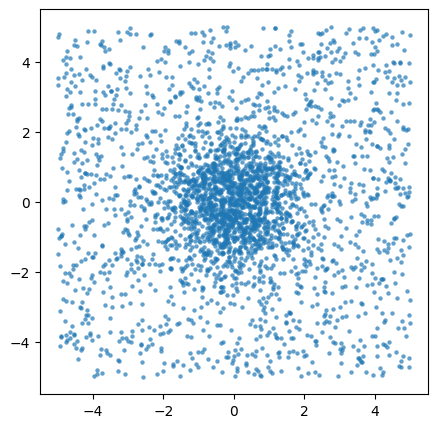

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(data[:,0], data[:,1], alpha = 0.7, linewidth = 0, s = 10)
#ax.scatter(data[674,0], data[674,1], alpha = 0.7, linewidth = 0, s = 100, c = 'r')

In [6]:
pak = PAk(data)
densities, err, k = pak.computeDensities()
freeEnergy = -1 * np.log(densities)

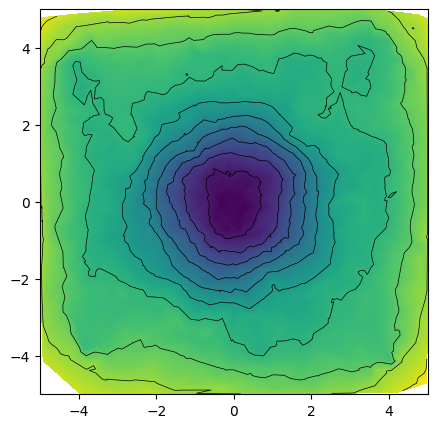

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.tricontour(data[:,0], data[:,1], freeEnergy, levels=10, linewidths=0.5, colors="k", linestyles = "solid")
ax.tricontourf(data[:,0], data[:,1], freeEnergy, levels=250)

In [8]:
dists = pak.computeDistsDensity()
indices = dists.argsort()[::-1][0:10]

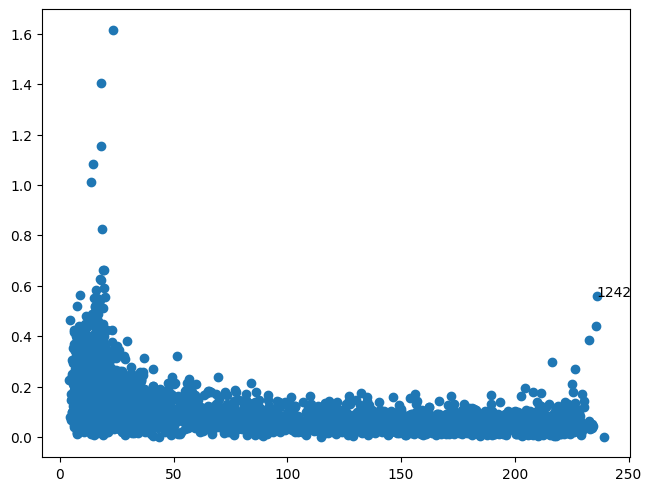

In [9]:
fig, ax = plt.subplots(layout='constrained')
ax.scatter(densities, dists)

densCutoff = 150 #x
distCutoff = .5 #y

for n in range(pak.nPoints):
  if densities[n] > densCutoff and dists[n] > distCutoff:
    ax.annotate(f"{n}", (densities[n], dists[n]))

## Let's test PAk:



In [131]:
def twodgauss(data, center, sigma):
    x = data[:,0]
    y = data[:,1]
    x0 = center[0]
    y0 = center[1]
    A = 1 / (2 * pi * sigma * sigma)
    gausspower = (np.power(x - x0, 2)/(2 * np.power(sigma, 2))) + (np.power(y - y0, 2)/(2 * np.power(sigma, 2)))
    return A * np.power(e, -1 * gausspower)

In [138]:
# We generate data from 9 normal distributions:
nGauss = [300, 1000, 3000]
nSigma = [0.1, 1, 3]
rng = np.random.default_rng(seed=1)
testData = np.array([], dtype=np.int64).reshape(0,2)
trueData = np.array([], dtype=np.int64)

for ptsIndex, pts in enumerate(nGauss):
  for sigmaIndex, sigma in enumerate(nSigma):
    mu = (ptsIndex * 25, sigmaIndex * 25)
    tempData = rng.normal(mu, sigma,(pts, 2))
    
    testData = np.concatenate((testData, tempData), axis = 0)
    trueData = np.concatenate((trueData, twodgauss(tempData, mu, sigma)), axis = 0)


In [142]:
#And apply PAk:
pak2 = PAk(testData)
densities2, err2, k2 = pak2.computeDensities()
freeEnergy2 = -1 * np.log(densities2)
dists2 = pak2.computeDistsDensity()

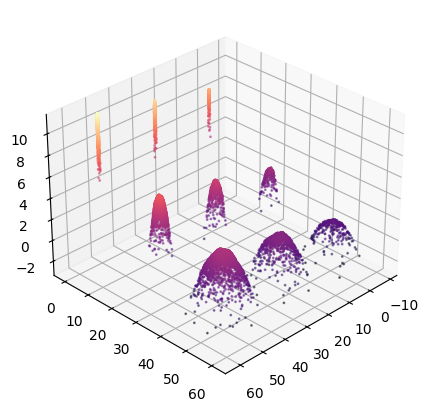

In [134]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection = "3d")
ax.view_init(30,45,0)
ax.scatter(testData[:,0], testData[:,1], np.log(densities2), s = 1, c = np.log(densities2), cmap = 'magma', alpha = .5)
#ax.scatter(testData[:,0], testData[:,1], np.log(trueData), s = 1, alpha = .5)

In [ ]:
pak2.plotDecGraph(1,1)

NameError: name 'self' is not defined

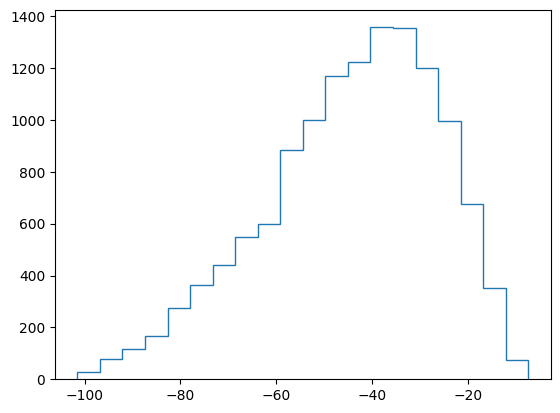

In [110]:
pull = (np.log(trueData) - np.log(densities2)) / err2[:,0]
counts, bins = np.histogram(pull, bins = 20)
plt.stairs(counts, bins)

In [108]:
from sklearn.neighbors import NearestNeighbors

In [107]:
testData.shape

(12900, 2)

In [38]:
nGauss = [300, 1000, 3000]
nSigma = [0.1, 1, 3]
rng = np.random.default_rng(seed=0)
testData = np.array([], dtype=np.int64).reshape(0,2)
trueData = np.array([], dtype=np.int64)

nn = 100
errkNN = np.array(100)

for ptsIndex, pts in enumerate(nGauss):
  for sigmaIndex, sigma in enumerate(nSigma):
    for i in range(100)


# Proteins


In [ ]:
#trp["temperature [k]"].unique()
#Output:
# array([300.  , 304.  , 308.15, 312.46, 316.92, 321.54, 326.31, 331.23,
#        336.31, 341.54, 346.92, 352.46, 358.15, 364.  , 370.  , 376.15,
#        382.46, 388.92, 395.54, 402.31, 409.23, 416.31, 423.54, 430.92,
#        438.46, 446.15, 454.  , 462.  , 470.15, 478.46, 486.92, 495.54,
#        504.31, 513.23, 522.31, 531.54, 540.92, 550.46, 560.15, 570.  ])
# We only use one temperature.

In [152]:
# From https://www.kaggle.com/datasets/tobiasle/trp-cage-dihedrals
# PDB: IL2Y
trp = pd.read_csv("./data/trp_300.00.csv")
trp = (trp
.drop(trp.columns[41:44], axis = 1)
.drop(["temperature [k]", "time [ps]", "replica id"], axis = 1)
.sample(frac = .25, random_state = 0) # We only use a subset.
)
trpArr = np.array(trp)

In [153]:
trp

,phi0,phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,...,psi9,psi10,psi11,psi12,psi13,psi14,psi15,psi16,psi17,psi18
415,-1.364,-1.450,-1.028,-1.221,-1.308,-1.114,-1.359,-1.144,2.211,1.348,...,-0.097,-2.310,-0.221,-0.144,0.293,-0.244,2.520,2.793,2.724,2.879
24375,-1.700,-1.387,-1.214,-1.138,-1.203,-1.126,-0.996,-0.884,2.378,0.875,...,-0.056,-2.251,-0.360,0.202,-0.345,0.131,2.582,2.747,2.234,2.449
21599,-1.872,-0.990,-1.120,-1.606,-1.122,-1.207,-1.076,-0.940,2.208,1.200,...,-0.086,-1.862,-0.152,0.127,-0.279,0.176,2.713,2.600,2.354,2.443
937,-1.277,-1.434,-1.115,-1.214,-1.720,-1.056,-1.059,-1.359,2.093,1.110,...,-0.193,-2.420,-0.359,-0.316,-0.231,-0.087,2.137,2.737,2.686,2.652
26595,-1.157,-1.024,-1.178,-1.155,-1.245,-1.023,-1.195,-1.384,2.801,1.217,...,-0.173,-2.889,-0.437,-0.262,-0.657,0.238,2.698,2.482,2.274,2.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,-1.304,-1.428,-1.020,-1.147,-1.104,-1.238,-1.218,-1.639,2.254,1.025,...,-0.073,-2.205,-0.419,0.290,0.063,0.054,2.582,3.005,2.312,2.368
24554,-0.786,-1.439,-1.009,-1.167,-1.034,-1.169,-1.213,-1.186,2.465,1.241,...,0.176,-2.242,-0.109,0.146,-0.341,0.078,2.739,2.908,2.442,2.536
35666,-1.234,-1.393,-1.080,-1.179,-1.394,-1.387,-1.187,-1.323,1.542,1.375,...,0.259,-2.286,-0.010,-0.194,2.953,0.166,2.748,2.888,2.643,2.714
30939,-1.058,-1.057,-1.339,-1.023,-1.122,-1.155,-1.141,-1.071,3.127,1.192,...,-0.576,-2.316,-0.101,-0.435,2.484,0.497,2.577,2.849,2.646,2.204


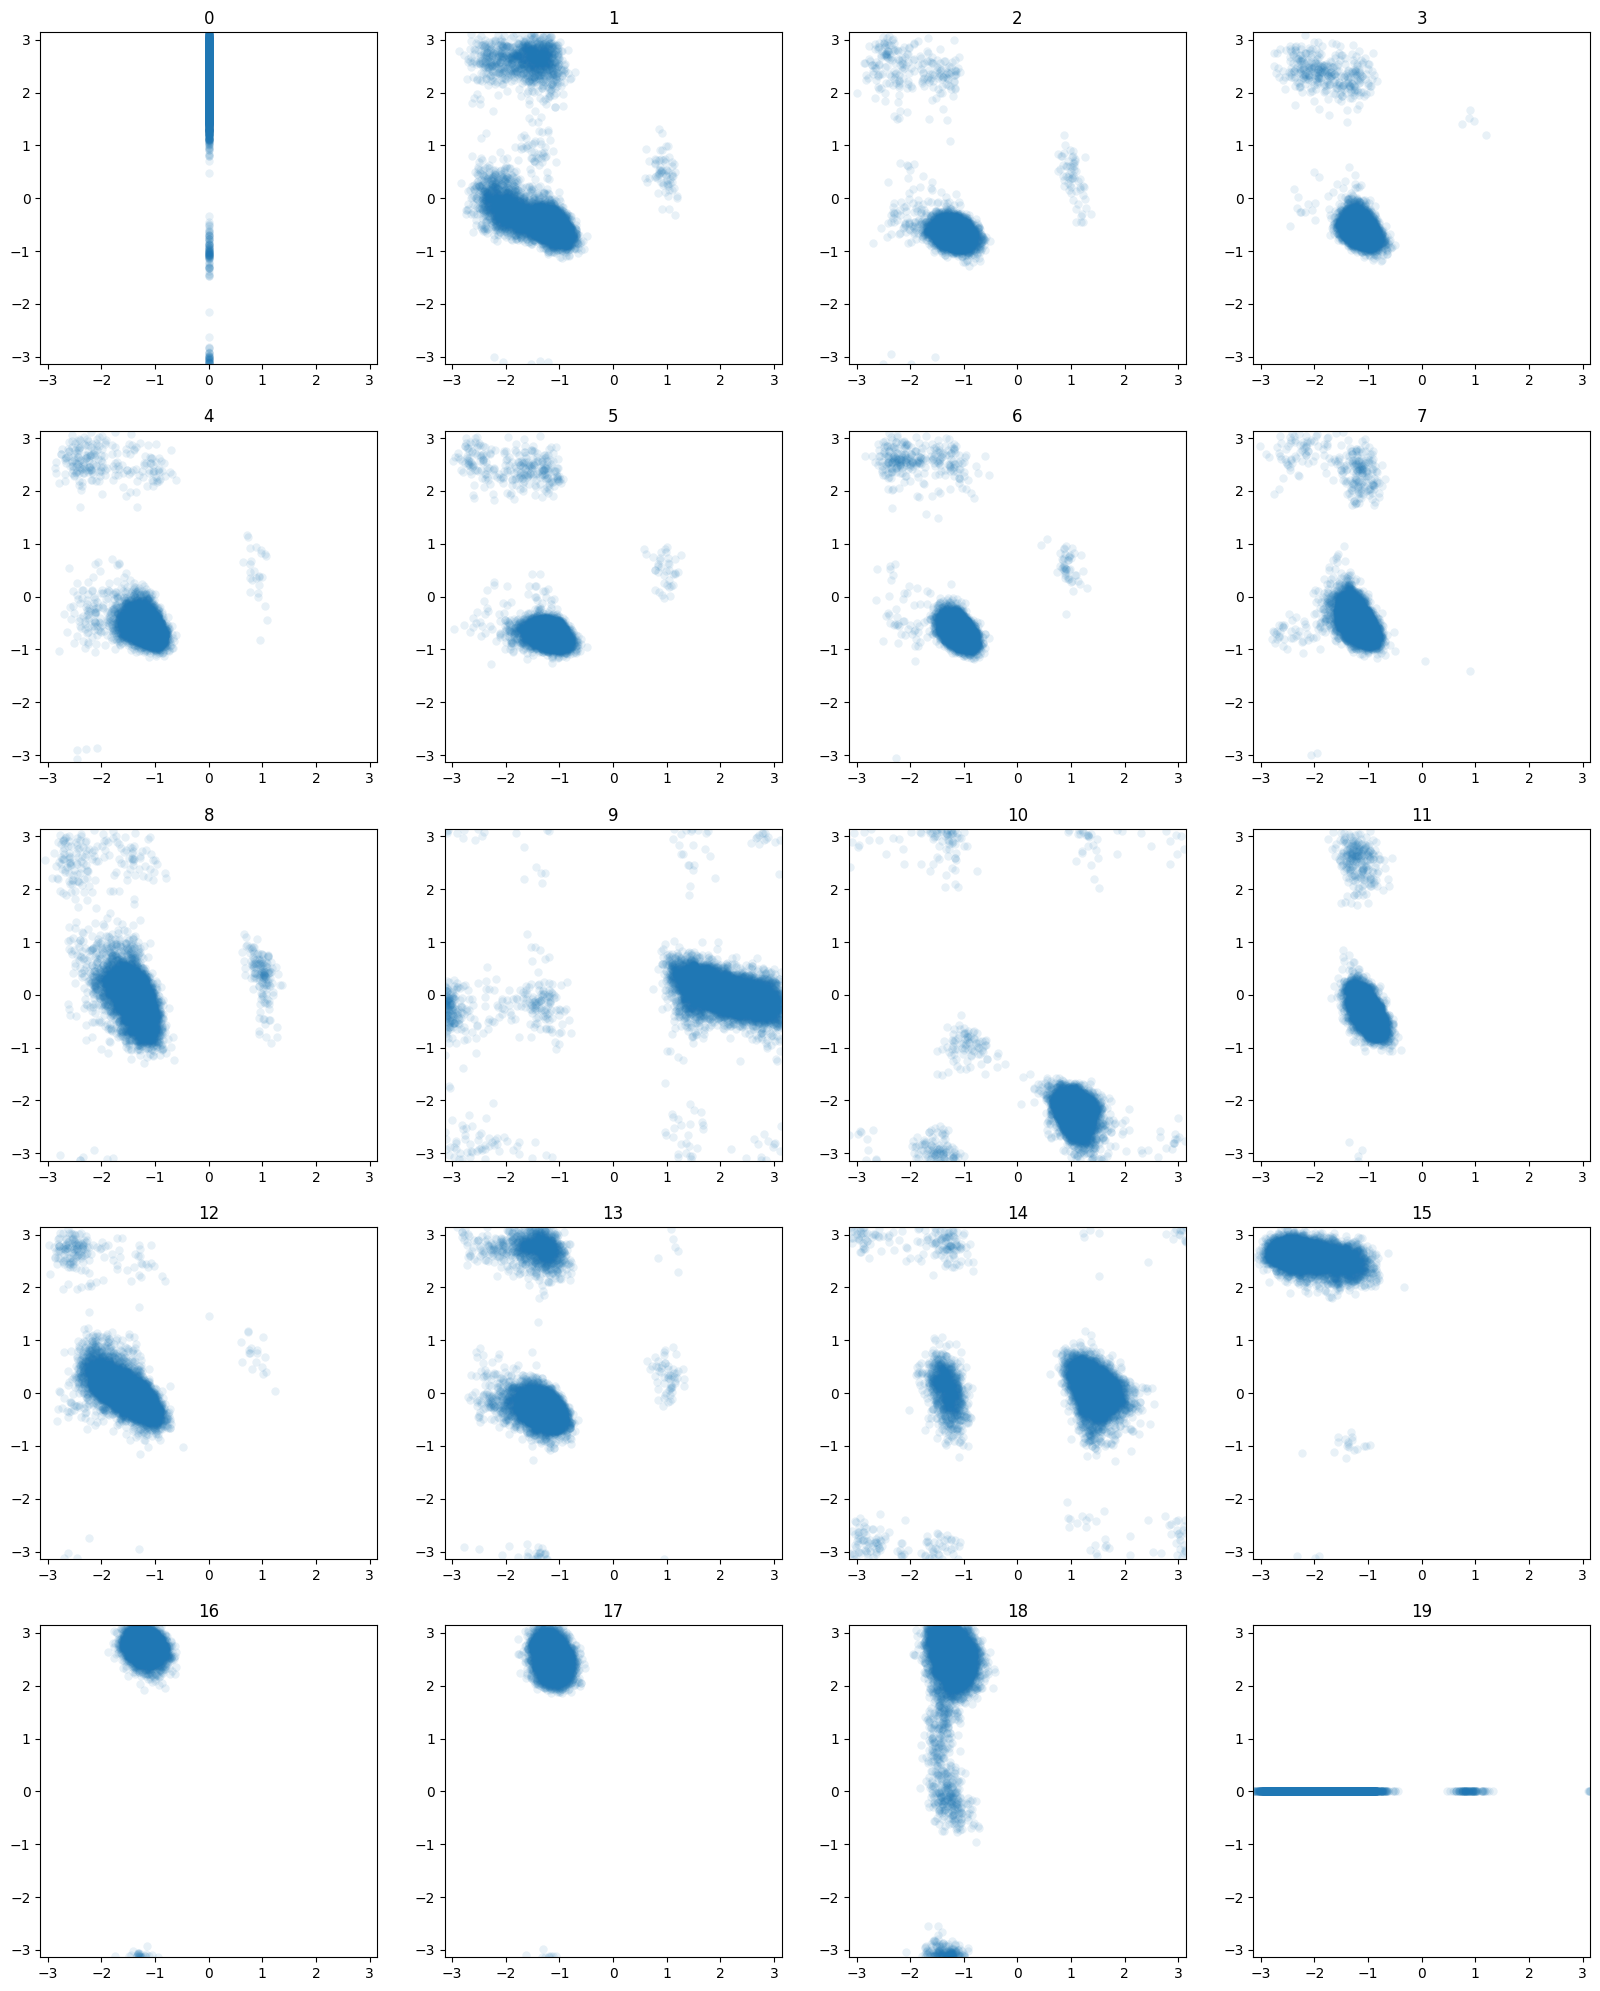

In [158]:
#Plotting the Ramachandran Plots.
ramachandran = np.c_[ np.zeros(trpArr.shape[0]), trpArr, np.zeros(trpArr.shape[0]) ]
fig, ax = plt.subplots(5,4, figsize = (20, 25))
ax = ax.reshape(1,-1)[0]
for i, a in enumerate(ax):
  a.set_title(f"{i}")
  a.set_xlim(left=-1 * pi, right=pi)
  a.set_ylim(bottom=-1 * pi, top=pi)
  a.scatter(ramachandran[:, i], ramachandran[:, i+20], alpha = 0.1, linewidth = 0)

In [119]:
pakTrp = PAk(trpArr)
densitiesTrp, errTrp, kTrp = pakTrp.computeDensities()
distsTrp = pakTrp.computeDistsDensity()

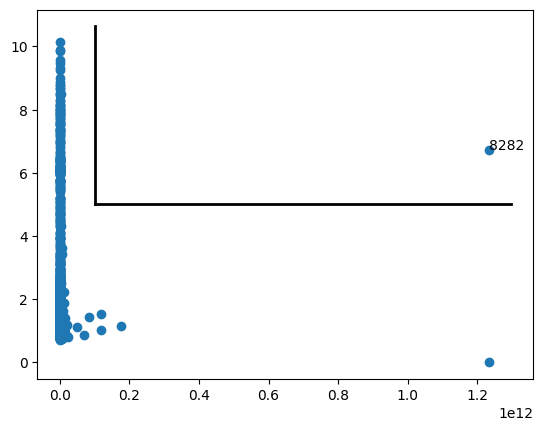

In [121]:
dencutoff = 1e11
distcutoff = 5

plt.scatter(densitiesTrp, distsTrp)

bottom, up = plt.ylim()
left, right = plt.xlim()

plt.plot([dencutoff, right], [distcutoff, distcutoff], color="k", linestyle="-", linewidth=2)
plt.plot([dencutoff, dencutoff], [distcutoff, up], color="k", linestyle="-", linewidth=2)

goodpts = []

for i in range(pakTrp.nPoints):
  if distsTrp[i] > distcutoff and densitiesTrp[i] > dencutoff:
    goodpts = goodpts + [i]
    plt.annotate(i, (densitiesTrp[i], distsTrp[i]))

In [122]:
pakTrp.computeDensityPeaks(distsTrp, goodpts)
clustersTrp = pakTrp.clusterArr

In [123]:
mds = MDS(max_iter=30)
trpMds = mds.fit_transform(trp)

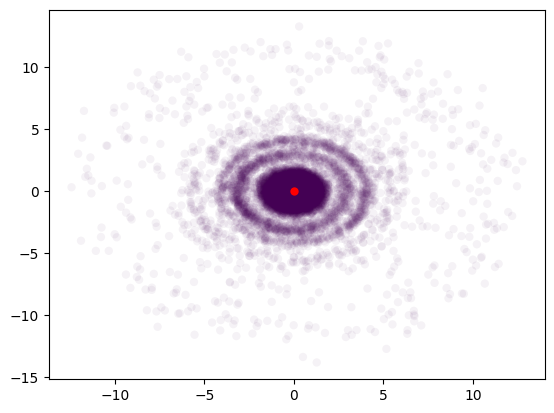

In [125]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(trpMds[:,0], trpMds[:,1], c = clustersTrp, alpha = 0.05, linewidth = 0)
ax.scatter(trpMds[goodpts,0], trpMds[goodpts,1], c = 'r', alpha = 1, linewidth = 0)

In [139]:
# Really rough, this shouldn't be here. But it works.
angles = np.rad2deg(trp.iloc[np.argmax(densitiesTrp)])
angnp = np.array(angles)
angnp = np.concatenate([[0], angnp, [0]])
for i in range(20):
    print(f"set_phipsi resi {i+1}, {angnp[i]}, {angnp[i+20]}")

set_phipsi resi 1, 0.0, 126.7382642829381
set_phipsi resi 2, -61.30648407899809, -32.94507322002233
set_phipsi resi 3, -67.20794936884556, -44.4042291226388
set_phipsi resi 4, -70.53110458060435, -31.455382952682196
set_phipsi resi 5, -65.83285066053159, -35.06501706200638
set_phipsi resi 6, -69.6716678879081, -40.56541189526228
set_phipsi resi 7, -62.452399669259734, -25.267438765269304
set_phipsi resi 8, -72.59375264307529, -29.163551772158904
set_phipsi resi 9, -81.93296470370773, 2.0626480624709633
set_phipsi resi 10, 100.55409304545947, 6.41712730546522
set_phipsi resi 11, 72.59375264307529, -116.99798176571409
set_phipsi resi 12, -49.96191973540778, -36.44011577032036
set_phipsi resi 13, -72.70834420210146, 1.5469860468532226
set_phipsi resi 14, -75.859612075321, -17.303325412950862
set_phipsi resi 15, 82.21944360127314, -4.354479242994256
set_phipsi resi 16, -116.08124929350477, 152.69325240236438
set_phipsi resi 17, -59.816793811657945, 159.5687459439343
set_phipsi resi 18, -59

![title](./pix/trp1.png)

![title](pix/trp2.png)

In [111]:
# From https://www.kaggle.com/datasets/tobiasle/trp-cage-dihedrals
# PDB: IL2Y
trp = pd.read_csv("./data/trp_470.15.csv")
trp = (trp
.drop(trp.columns[41:44], axis = 1)
.drop(["temperature [k]", "time [ps]", "replica id"], axis = 1)
.sample(frac = .25, random_state = 0) # We only use a subset.
)
trpArr = np.array(trp)

In [112]:
pakTrp = PAk(trpArr)
densitiesTrp, errTrp, kTrp = pakTrp.computeDensities()
distsTrp = pakTrp.computeDistsDensity()

/tmp/ipykernel_8438/1755190604.py:80: RuntimeWarning: divide by zero encountered in divide
  densities = kArray/vkArray
/tmp/ipykernel_8438/1755190604.py:83: RuntimeWarning: divide by zero encountered in divide
  ((4 * kArray) + 2) / ((kArray-1) * kArray)


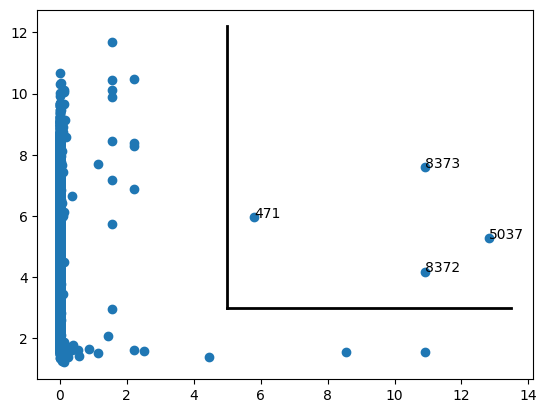

In [117]:
dencutoff = 5
distcutoff = 3

plt.scatter(densitiesTrp, distsTrp)

bottom, up = plt.ylim()
left, right = plt.xlim()

plt.plot([dencutoff, right], [distcutoff, distcutoff], color="k", linestyle="-", linewidth=2)
plt.plot([dencutoff, dencutoff], [distcutoff, up], color="k", linestyle="-", linewidth=2)

goodpts = []

for i in range(pakTrp.nPoints):
  if distsTrp[i] > distcutoff and densitiesTrp[i] > dencutoff:
    goodpts = goodpts + [i]
    plt.annotate(i, (densitiesTrp[i], distsTrp[i]))

In [118]:
pakTrp.computeDensityPeaks(distsTrp, goodpts)
clustersTrp = pakTrp.clusterArr

In [122]:
mds = MDS(n_components = 3,max_iter=30)
trpMds = mds.fit_transform(trp)

KeyboardInterrupt: 

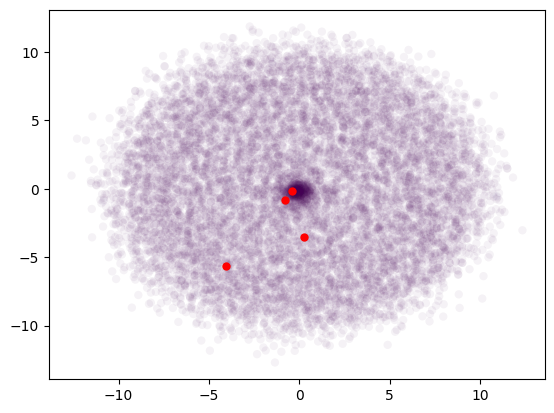

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(trpMds[:,0], trpMds[:,1], c = clustersTrp, alpha = 0.05, linewidth = 0)
ax.scatter(trpMds[goodpts,0], trpMds[goodpts,1], c = 'r', alpha = 1, linewidth = 0)